This notebook requires the dataframe from https://data.mendeley.com/datasets/n795jd566x/1

# Constrained Linear Model HMM background:
_______

Let $v_1(n)$ and $v_2(n)$ denote some input and output time series, respectively, for $n=1,\dots,T+2L$. We construct the $D=2L+1$ dimensional input and output vectors for $t=1,\dots,T$
\begin{aligned}
\vec{x}_t &= [v_1(t) \dots v_1(t+L) \dots v_1(t+2L)]^\top
\\
\vec{y}_t &= [v_2(t) \dots v_2(t+L) \dots v_2(t+2L)]^\top
\end{aligned}
We construct a linear model to predict the output vector
$$
\vec{y}_t = \mathbf{W}^{(k)}\vec{x}_t + \vec{b}^{(k)} + \epsilon_t
$$
where the weights matrix $\mathbf{W}^{(k)} \in \mathbb{R}^{D^2}$, the bias vector $\vec{b}^{(k)} \in \mathbb{R}^D$, and we model $\epsilon_t \sim \mathcal{N}(0,\Sigma^{(k)})$ as spherical Gaussian noise where $\Sigma^{(k)} = \sigma^2 \mathbb{I}$ is tied across all states $k=1,\dots,K$. We constrain $\mathbf{W}^{(k)}$ to have symmetric Toeplitz structure, reducing the number of free parameters from $D^2$ to $D$. We also restrict the bias to be a constant vector $\vec{b}^{(k)} = b^{(k)} \vec{1}$ where $b^{(k)} \in \mathbb{R}$. 

Optimization of the expected complete-data log likelihood (ECLL) with respect to model parameters reveals each row of the weights matrix acts as a filter that, when convoled with the autocorrelation of the input signal, is proportional to the cross-correlation between the input and output signals. Therefore, each state $k$ identifies a unique mode of cross-correlation between signals.

In this notebook, we leverage this constrained linear model HMM (cLM-HMM) to identify social interactions between freely-swimming larval zebrafish. We collected data across the following sensory conditions:
1. Light (lights on, hair cells intact)
2. Dark (lights off, hair cells intact)
3. Neo (lights on, hair cells ablated)
4. Neo dark (lights off, hair cells ablated)

We then identified the sensory contributions to state expression. In summary, we identified in- and out-of-phase interaction states, as well as a null state (uncorrleated movement). In-phase coupling primarily occurs at close range in parallel/anti-parallel alignments and is most frequently expressed in pairs with intact hair cells (even in the dark!). This suggests that in-phase swimming is driven by mechanosensory feedback. Out-of-phase coupling tends to occur at mid-ranges and is most frequently expressed in the Neo condition, suggesting this mode relies more on visual feedback. 

# __Step 1__: Import libraries and load data
___

## 1a. Optionally restrict notebook to run on subset of CPUs

While Dynamax is capable of utilizing GPUs to efficiently run model fits, we can restrict this notebook to run on CPUs. First check how many cores are available. Then select the cores you want to use to run this notebook and restrict computations to this subset.

In [1]:
import psutil

max_workers = psutil.cpu_count(logical=True)
print(f"Available cores: {max_workers}")

Available cores: 64


In [2]:
# choose subset of cores to utilize 
cpu_list = list(range(0,32))

assert len(cpu_list) < max_workers

In [ ]:
import os

def set_cpu_affinity_for_process(p, cpu_list):
    """Sets the CPU affinity for a process."""
    try:
        p.cpu_affinity(cpu_list)
    except psutil.AccessDenied:
        print(f"Could not set CPU affinity for process {p.pid}")

# Get the current process
main_process = psutil.Process(os.getpid())

# Set CPU affinity for the main process
set_cpu_affinity_for_process(main_process, cpu_list)

# Set CPU affinity for all child processes
for child in main_process.children(recursive=True):
    set_cpu_affinity_for_process(child, cpu_list)

print(f"CPU affinity set to: {main_process.cpu_affinity()} for the main process")

CPU affinity set to: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] for the main process


If you want to use GPUs anyway, you can change the following code block.

In [4]:
# optionally utilize GPUs and specify fraction of memory prelocated for dynamax
use_GPUs = False
preallocate_mem = True if use_GPUs else None
mem_frac = 0.5 if preallocate_mem else None

if use_GPUs: 
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(preallocate_mem)  # optionally preallocate memory on GPU
    if preallocate_mem:
        os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = str(mem_frac)    # fraction of memory to preallocate
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide available GPU devices so code will run on CPUs
    os.environ["JAX_PLATFORMS"] = "cpu"      # force JAX to use CPU backend

## 1b. Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

from itertools import count
from scipy import signal
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import ImageGrid
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import KFold

# import libraries for model fits
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import config
from dynamax.utils.utils import pytree_slice
from dynamax.hidden_markov_model import ConstrainedLinearRegressionSharedSphericalGaussianHMM

# display CUDA compatible GPUs available (or CPU if there are none)
print("Visible devices: {}".format(jax.devices()))

Visible devices: [CpuDevice(id=0)]


## 1c. Load data

This notebook is designed to work with either the final analyzed dataframe `coupled_analyzed_observed_df` that will be uploaded to Mendelev, or it works with the dataframe that we get out from the pre-processing notebooks `obs_frame_df`.

In [6]:
use_analyzed_df = False

if use_analyzed_df:
    # define file path and load
    path = "/home/alesak/workspace/cLMHMM_paper_analysis/data/"
    analyzed_df_name = "coupled_analyzed_observed_df.feather"
    df = pd.read_feather(path + analyzed_df_name) 
    print("Analyzed observed df size: {:.2f} MB".format(df.memory_usage(index=True).sum() / 1024**2))

else:
    # define file paths
    path = "/home/alesak/workspace/cLMHMM_paper_analysis/data/"
    obs_df_name = "obs_frame_df.feather"      # empirical data

    # load dataframes
    df = pd.read_feather(path + obs_df_name)

    # print sizes
    print("Observed df size: {:.2f} MB".format(df.memory_usage(index=True).sum() / 1024**2))

Observed df size: 272.93 MB


In [7]:
# define FPS and resolution (pixels per mm) of recordings
FPS = 60
pix_mm = 18.9

# __Step 2__: Fit model globally to all fish pairs and permutations of focal and partner fish
___

## 2a. Define functions for constructing inputs & outputs

In [8]:
# function to denoise downsampled data
def denoise_ds(ipt_arr, obs_arr, ipt_lag, min_thr=0.1):
    if ipt_lag>0:
        ipt_arr = np.where(ipt_arr < min_thr, 0, ipt_arr)
        ipt_arr = np.where(ipt_arr > 1.0,     1, ipt_arr)
    obs_arr = np.where(obs_arr < min_thr, 0, obs_arr)
    obs_arr = np.where(obs_arr > 1.0,     1, obs_arr)
    return ipt_arr, obs_arr


def get_single_fish_ids_inputs_obs(df,f_num,q,lag,ipt_lag,denoise):
    # get time series that we will use to construct the inputs & outputs
    ipt_fish_num = -1*f_num + 1
    ipt_fish_bout_seq = np.array(df[f'f{ipt_fish_num}_bout_seq'].tolist(), dtype=int)
    obs_fish_bout_seq = np.array(df[f'f{f_num}_bout_seq'].tolist(), dtype=int)
    assert len(ipt_fish_bout_seq) == len(obs_fish_bout_seq)

    # discard frames that do not allow for full lag
    num_frames = len(ipt_fish_bout_seq)
    max_lag = max(lag, ipt_lag)
    valid_indices = np.arange(max_lag, num_frames - max_lag)

    # initialize inputs and outputs with NaNs
    inputs = np.full((num_frames, 2 * ipt_lag + 1), np.nan)
    obs = np.full((num_frames, 2 * lag + 1), np.nan)

    # construct symmetrically time-lagged inputs & outputs (vectorized for speed)
    if max_lag > 0:
        inputs[max_lag:-max_lag] = np.lib.stride_tricks.sliding_window_view(ipt_fish_bout_seq, 2*ipt_lag + 1)[valid_indices - ipt_lag]
        obs[max_lag:-max_lag] = np.lib.stride_tricks.sliding_window_view(obs_fish_bout_seq, 2*lag + 1)[valid_indices - lag]
    else:
        inputs = np.reshape(ipt_fish_bout_seq, (-1,1))
        obs = np.reshape(obs_fish_bout_seq, (-1,1))

    # downsample each input/output vector by factor 'q'
    if q > 1: 
        obs = signal.decimate(obs, q, n=8, ftype='iir') if lag > 0 else obs
        inputs = signal.decimate(inputs, q, n=8, ftype='iir') if ipt_lag > 0 else inputs

        #denoise and set floor/ceiling to 0/1
        if (denoise==True):
            inputs, obs = denoise_ds(inputs, obs, ipt_lag, min_thr=0.1)

    # make array to keep track of fish ids
    fish_id = np.full(num_frames, f_num, dtype=int)
    if max_lag > 0:
        frame_id = np.full(num_frames, np.nan)
        frame_id[max_lag:-max_lag] = valid_indices
    else:
        frame_id = valid_indices
    
    # concat input & fish ids
    f_ids = np.vstack((frame_id, fish_id)).T
    return f_ids, inputs, obs


def process_group(df, g, f_num, q, lag, ipt_lag, denoise):
    # get ids, ipts, obs
    g_sel = (df['group']==g)
    f_ids, inputs, obs = get_single_fish_ids_inputs_obs(df[g_sel], f_num, q, lag, ipt_lag, denoise)
    focal_fish = np.array(f_ids.T[1], dtype=int)

    # get group df
    g_df = df[g_sel].copy()
    g_df.insert(22, 'focal_fish', focal_fish)
    g_df.insert(23, 'input', np.round(inputs, 4).tolist())
    g_df.insert(24, 'output', np.round(obs, 4).tolist())
    
    valid_IO = ~np.isnan(inputs).any(axis=1)
    g_df.insert(25, 'valid_IO', valid_IO)

    return g_df.reset_index(drop=True), f_ids, inputs, obs


def get_group_data(df, gs, f_num, q, lag, ipt_lag, num_workers, denoise=True):
    df_list = []
    g_idxs, g_ipts, g_obs = [], [], []

    assert num_workers <= os.cpu_count()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(lambda g: process_group(df, g, f_num, q, lag, ipt_lag, denoise), gs)

    for result in results:
        g_df, f_ids, inputs, obs = result
        df_list.append(g_df)
        
        # append non-nan values to lists 
        mask = ~np.isnan(inputs).any(axis=1)
        g_idxs.append(f_ids[mask])
        g_ipts.append(inputs[mask])
        g_obs.append(obs[mask])

    return g_idxs, g_ipts, g_obs, pd.concat(df_list)


def get_data(df, gs, f_num, q, lag, ipt_lag, num_workers=1, denoise=True):
    # ensure valid focal fish numbers were passed
    assert f_num in [0, 1, 'both']

    # drop columns that may already present if the final analyzed
    # dataframe was loaded at the start of this notebook
    drop_cols = [
        'focal_fish', 'input', 'output', 'posts', 'thresh_state', 
        'state', 'local_posts', 'local_thresh_state', 'local_state', 'valid_IO']
    for col in drop_cols:
        if col in df.columns.values.tolist(): 
            df = df.drop(columns=[col])

    # print conditions, groups, and focal fish num(s)
    g_sel = df["group"].isin(gs)
    cs = df[g_sel]["class"].unique().tolist()
    f_nums = [f_num] if f_num != 'both' else [0, 1]
    print('Conditions:', cs)
    print('Groups: {}'.format(gs))
    print('Focal fish number(s): {}'.format(f_nums))

    # get group data
    bdfs, idxs, ipts, obs = [],[],[],[]
    for i, f in enumerate(f_nums):
        print('Constructing dataframe with fish {} as the focal fish...'.format(f))
        g_idxs, g_ipts, g_obs, bdf = get_group_data(df, gs, f, q, lag, ipt_lag, num_workers, denoise=denoise)
        idxs += g_idxs
        ipts += g_ipts
        obs += g_obs
        bdf["group"] = i*len(gs) + np.array(bdf["group"], dtype=int)
        bdfs.append(bdf)

    if f_num == 'both':
        print("Stacking dataframes...")
        
    bdfs = pd.concat(bdfs)
    cols_to_make_cat = ["focal_fish", "group"]
    bdfs[cols_to_make_cat] = bdfs[cols_to_make_cat].astype("category")
    print("Completed.")

    return bdfs, idxs, ipts, obs

## 2b. Construct inputs and outputs 

In [9]:
q = 5           # downsample factor for input/output vectors (q = 5 recommended)
lag = 120       # frames to lag observations forward and backward (2 seconds recommended)
ipt_lag = lag   # frames to lag input forward and backward (2 seconds recommended)
f_num = "both"  # choose the focal fish num. Input fish num is -f_num + 1. Select 'both' to stack data from each fish, or choose 0 or 1 for a single fish
denoise = True  # clean up downsampled inputs & observations by setting floor of 0 and ceiling of 1

# select fish pairs (groups) to construct data from
# groups = [5,6]  # select any subset of groups
# groups = df[df["class"].isin([1])]["group"].unique().tolist()  # select all groups w/in specified condition(s)
groups = df["group"].unique().tolist()  # select all groups across all conditiions

# optionally parallelize data construction (default = 1, recommend more for faster construction!)
num_workers = 10  

# get inputs, emissions (observations), and construct dataframe
bdf, g_idx, g_input, g_obs = get_data(df, groups, f_num, q, lag, ipt_lag, num_workers, denoise=True)

# get new group numbers if stacking dataframes
if f_num == "both":
    groups = bdf["group"].unique().tolist()

Conditions: [0, 1, 2, 3]
Groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Focal fish number(s): [0, 1]
Constructing dataframe with fish 0 as the focal fish...
Constructing dataframe with fish 1 as the focal fish...
Stacking dataframes...
Completed.


In [10]:
# concat group data and get dimensions
inputs = np.vstack(g_input)
emissions = np.vstack(g_obs)
input_dim = inputs.shape[-1]
emission_dim = emissions.shape[-1]

# optionally batch data into groups (recommended)
batches = True

num_batches = len(groups) if batches else 1
inputs = np.reshape(inputs, (num_batches, -1, input_dim))
emissions = np.reshape(emissions, (num_batches, -1, emission_dim))
num_timesteps = emissions.shape[1]

print('Input shape: ',inputs.shape)
print('Output shape:',emissions.shape)

Input shape:  (106, 53757, 49)
Output shape: (106, 53757, 49)


## 2c. Fit single instance of model

In [11]:
# specify whether to load params or not
Load = True

# set hyper params
num_states = 3       # num of latent states in model
symm_weights = True  # constrain toeplitz weights to be symmetric
N_iters = 40         # num of EM iterations
TOL = 1e-4           # convergence threshold of LL for early stopping

# select model params to fit
fit_params_dict = {"fit_initial_state_probs": True,
                   "fit_transition_matrix": True,
                   "fit_weights": False,
                   "fit_biases": False,
                   "fit_scales": False} 

if Load:
    # load dict of model params
    current_folder = os.path.dirname(os.path.abspath("__file__"))
    params_path = os.path.join(current_folder, 'best_fit_model_params.npz')
    model_params = np.load(params_path)
    
    # unpack params
    tmat = model_params["transition_matrix"]
    init_probs = model_params["initial_probs"]
    flat_weights = model_params["flat_weights"]
    biases = model_params["biases"]
    scales = model_params["scales"]

  0%|          | 0/40 [00:00<?, ?it/s]

LL: -99443792.00   LL/samp: -17.45


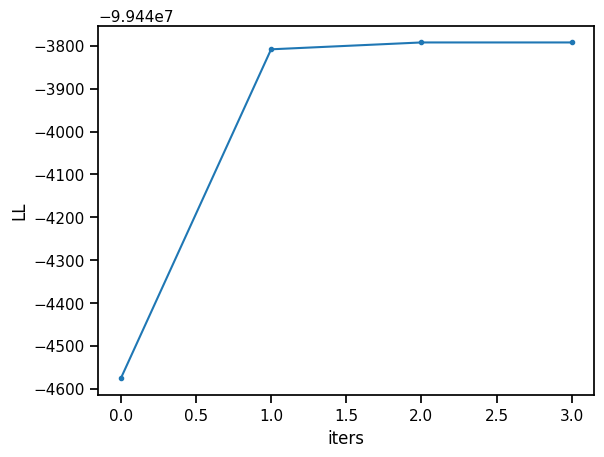

In [12]:
# instantiate model
hmm = ConstrainedLinearRegressionSharedSphericalGaussianHMM(
    num_states, 
    input_dim, 
    emission_dim, 
    symmetric=symm_weights, 
    transition_matrix_stickiness=0
)

# initialize model params
if Load:
    # We let states 0 and 2 denote the in-phase and null states, respectively. To improve classification accuracy, 
    # we set the null bias = 0.8 * best-fit in-phase bias. This reduces the number of null interactions that are 
    # classified as social interactions
    biases[2] = 0.8 * biases[0]

    init_params, param_props = hmm.initialize(
        initial_probs = init_probs,
        transition_matrix = tmat,
        emission_flat_weights = flat_weights,
        emission_biases = biases,
        emission_scales = scales
    )
else:
    keys = map(jr.PRNGKey, count()) 
    init_params, param_props = hmm.initialize(key=next(keys), method="random")

# specify which model params will be fit
param_props.initial.probs.trainable                 = fit_params_dict["fit_initial_state_probs"]
param_props.transitions.transition_matrix.trainable = fit_params_dict["fit_transition_matrix"]
param_props.emissions.flat_weights.trainable        = fit_params_dict["fit_weights"]
param_props.emissions.biases.trainable              = fit_params_dict["fit_biases"]
param_props.emissions.scales.trainable              = fit_params_dict["fit_scales"]

# fit model and get training lls
fit_params, lls = hmm.fit_em_while(
    init_params, param_props, emissions, inputs=inputs, num_iters=N_iters, tolerance=TOL, verbose=True
)
lls_clean = lls[jnp.isfinite(lls)]

# plot training log likelihoods
print("LL: {:.2f}   LL/samp: {:.2f}".format(lls_clean[-1], lls_clean[-1] / (num_batches * num_timesteps)))
plt.plot(lls_clean,'.-')
plt.xlabel("iters")
plt.ylabel("LL")
plt.show()

## 2d. Plot observation model parameters

In [13]:
def plot_weights(weights, biases, lag, ipt_lag, num_states, FPS, define_lim=False, vmin=-0.06, vmax=0.18, 
                 display_bias=False,cmap="seismic", interp="spline16", figsize=(12,4)):
    
    if not define_lim: 
        vmin, vmax = np.min(weights), np.max(weights)

    # make assymetric seismic colormap using TwoSlopeNorm: vmin = blue, 0 = white, vmax = dark red
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # set plot params
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,num_states), axes_pad=0.25, cbar_location="right", cbar_mode="single", cbar_size="5%", cbar_pad=0.25)

    # plot
    for i in range(num_states):
        im = grid[i].imshow(weights[i],interpolation=interp,norm=norm,extent=[-lag/FPS,lag/FPS,-ipt_lag/FPS,ipt_lag/FPS],cmap=cmap)
        grid[i].set_xticks(np.linspace(-lag/FPS,lag/FPS,5))
        grid[i].set_yticks(np.linspace(-ipt_lag/FPS,ipt_lag/FPS,5))
        grid[i].set_xlabel('')
        grid[i].set_ylabel('Output Lag (s)',fontdict={'size':12})
        if i>0: plt.yticks([]); plt.ylabel('')
        if i==num_states-1: 
            cbar = plt.colorbar(im, cax=grid.cbar_axes[0])
            cbar.ax.set_yscale('linear')
        grid[i].set_title(r'$\mathbf{{W}}^{{({})}}$'.format(i))
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        if display_bias:
            grid[i].text(x=0.65,y=1.65,s=r'$b^{{({})}} = {:.2f}$'.format(i,biases[i]))

    fig.add_subplot(111, frameon=False) 
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Input Lag (s)       ',fontdict={'size':12},labelpad=0)
    plt.show()

In [14]:
# optionally permute order of states
permute_states = False
if permute_states:
    perm = np.array([0,2,1])
    fit_params = hmm.permute(fit_params, perm)

# get best fit model params
tmat = fit_params.transitions.transition_matrix
init_prob = fit_params.initial.probs
flat_weights = fit_params.emissions.flat_weights
weights = hmm.emission_component.get_weights(flat_weights)
biases = fit_params.emissions.biases
scales = fit_params.emissions.scales

# package in dict
params = {"transition_matrix": np.array(tmat),
          "initial_probs": np.array(init_prob),
          "flat_weights": np.array(flat_weights),
          "weights": np.array(weights),
          "biases": np.array(biases),
          "scales": np.array(scales)
}

Scale: 0.342
Biases: 0.14, 0.26, 0.11


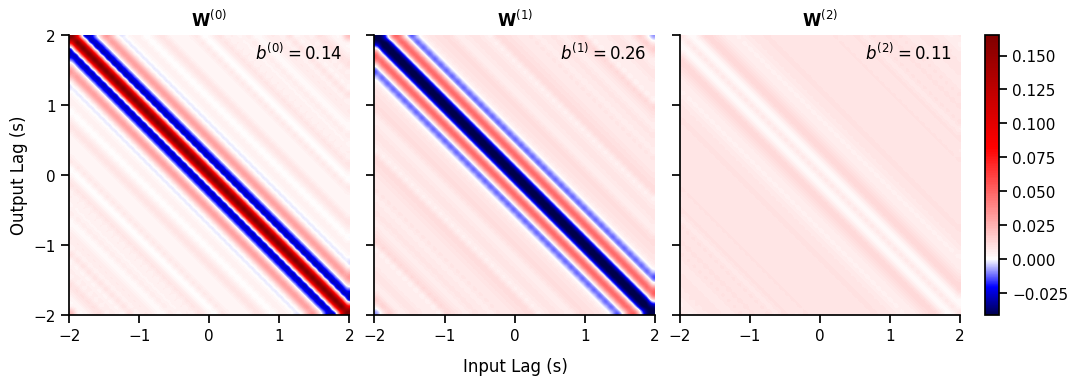

In [15]:
# print scale and biases
formatted_biases = [f"{b:.2f}" for b in params["biases"]]
print("Scale: {:.3f}".format(params["scales"][0]))
print(f"Biases: {', '.join(formatted_biases)}")

# choose colormap and interpolation for weights plot
cmp = "seismic"
interp = "spline16" # "none"

# optionally display biases on plots
display_bias = True

# plot weights
plot_weights(weights, biases, lag, ipt_lag, num_states, FPS, cmap=cmp, interp=interp, display_bias=display_bias)

Since the matrices are Toeplitz (have constant diagonals), a single slice is sufficient to capture most of the structure in the matrix.

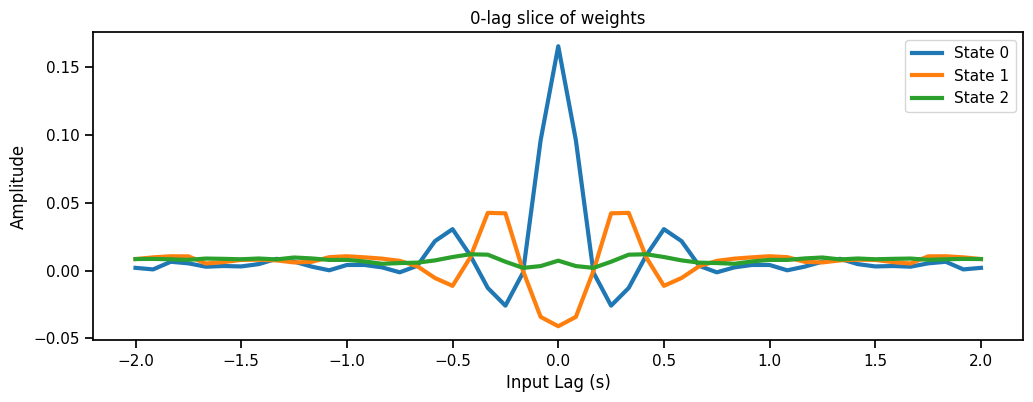

In [16]:
# get 0 lag slice
midpoint = int((emission_dim-1)/2)
wks_slice = params["weights"][:,midpoint,:]

# get x data in seconds
xs = np.linspace(-lag/FPS,lag/FPS,emission_dim)

# plot slices
figsize = (12,4)
fig = plt.figure(figsize=figsize)
for i in range(num_states):
    plt.plot(xs,wks_slice[i],'-',lw=3,label="State {}".format(i))
plt.xlabel("Input Lag (s)")
plt.ylabel("Amplitude")
plt.title("0-lag slice of weights")
plt.legend()
plt.show()

# __Step 3__: Globally fit data to coupled model with fixed observation model parameters
_____

When dealing with coupled data, it is not clear which signal should be treated as the input and which as the emission. In this case, the emissions $\vec{y}_t$ could be predicted by:
$$
    \vec{y}_t = \mathbf{W}^{(k)} \vec{x}_t + b^{(k)}\vec{1}
$$
Similarly, the inputs could be predicted by:
$$
    \vec{x}_t = \mathbf{W}^{(k)} \vec{y}_t + b^{(k)}\vec{1}
$$
Since the data is coupled, the assigned state $k$ at time $t$ should remain consistent across both permutations. However, when fitting noisy data, each permutation may lead to different state assignments for some frames. To ensure consistent state assignment for each time point, we fit a coupled model simultaneously across both permutations. We do this by passing the stacked emissions $\vec{y}^{(2)}_t = (\vec{y}_t, \vec{x}_t)$ and inputs $\vec{x}^{(2)}_t = (\vec{x}_t, \vec{y}_t)$ into our model and calling `fit_em()` with `coupled_IO_fit = True`.

We then fix the observation model parameters obtained from the global fit in step 1 (weights, biases, spherical covariance) and fit the remaining parameters (initial probabilities, transition matrix) to each fish pair individually. This allows us to compare state expression between pairs within condition, and across conditions.

## 3a. Construct coupled inputs and outputs

In [17]:
q = 5           # downsample factor for input/output vectors (q = 5 recommended)
lag = 120       # frames to lag observations forward and backward (2 seconds recommended)
ipt_lag = lag   # frames to lag input forward and backward (2 seconds recommended)
f_num = 0       # choose the focal fish num. Input fish num is -f_num + 1. Select 'both' to stack data from each fish, or choose 0 or 1 for a single fish
denoise = True  # clean up downsampled inputs & observations by setting floor of 0 and ceiling of 1

# select fish pairs (groups) to construct data from
# groups = [5,6]  # select any subset of groups
# groups = df[df["class"].isin([1])]["group"].unique().tolist()  # select all groups w/in specified condition(s)
groups = df["group"].unique().tolist()  # select all groups across all conditiions

# optionally parallelize data construction (default = 1, recommend more for faster construction!)
num_workers = 10

# get inputs, emissions (observations), and construct dataframe
bdf, g_idx, g_input, g_obs = get_data(df, groups, f_num, q, lag, ipt_lag, num_workers, denoise=True)

Conditions: [0, 1, 2, 3]
Groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
Focal fish number(s): [0]
Constructing dataframe with fish 0 as the focal fish...
Completed.


In [18]:
# stack inputs and outputs along last dimension
dual_emissions = np.dstack((g_obs, g_input))
dual_inputs = np.dstack((g_input, g_obs))
input_dim = g_input[0].shape[-1]
emission_dim = g_obs[0].shape[-1]
print("Input dim: {}".format(input_dim))
print("Emission dim: {}".format(emission_dim))

# optionally batch data into groups (recommended)
batches = True
num_batches = len(groups) if batches else 1
dual_inputs = np.reshape(dual_inputs, (num_batches, -1, dual_inputs.shape[-1]))
dual_emissions = np.reshape(dual_emissions, (num_batches, -1, dual_emissions.shape[-1]))
num_timesteps = dual_emissions.shape[1]

print('Stacked input shape: ',dual_inputs.shape)
print('Stacked output shape:',dual_emissions.shape)

Input dim: 49
Emission dim: 49
Stacked input shape:  (53, 53757, 98)
Stacked output shape: (53, 53757, 98)


In [19]:
a = os.path.dirname(os.path.abspath("__file__"))
os.path.join(a, 'best_fit_model_params.npz')

'/home/alesak/workspace/cLMHMM_paper_analysis/notebooks/best_fit_model_params.npz'

## 3b. Fit model to each pair

In [20]:
# optionally load params, else use the params obtained from previous step
preload_model_params = False

if preload_model_params:
    current_folder = os.path.dirname(os.path.abspath("__file__"))
    params_path = os.path.join(current_folder, 'best_fit_model_params.npz')
    model_params = np.load(params_path)
else:
    model_params = params  # use fit params from global fit in previous step

# unpack params
tmat = model_params["transition_matrix"]
init_probs = model_params["initial_probs"]
flat_weights = model_params["flat_weights"]
weights = model_params["weights"]
biases = model_params["biases"]
scales = model_params["scales"]

In [21]:
# choose hyper params
num_states = 3       # num of latent states in model
symm_weights = True  # constrain toeplitz weights to be symmetric
N_iters = 40         # num of EM iterations
TOL = 1e-4           # convergence threshold of LL for early stopping

# select model params to fit (only want to fit initial state probs and trans mat here)
fit_params_dict = {
    "fit_initial_state_probs": True,
    "fit_transition_matrix": True,
    "fit_weights": False,
    "fit_biases": False,
    "fit_scales": False
} 

In [22]:
# instantiate model
hmm = ConstrainedLinearRegressionSharedSphericalGaussianHMM(
    num_states,
    input_dim,
    emission_dim,
    symmetric=symm_weights,
    coupled_IO_fit=True, 
)

# initialize parameters
init_params, param_props = hmm.initialize(
    initial_probs=init_probs,
    transition_matrix=tmat,
    emission_flat_weights=flat_weights,
    emission_biases=biases,
    emission_scales=scales
)

# specify which model params to fit
param_props.initial.probs.trainable = fit_params_dict["fit_initial_state_probs"]
param_props.transitions.transition_matrix.trainable = fit_params_dict["fit_transition_matrix"]
param_props.emissions.flat_weights.trainable = fit_params_dict["fit_weights"]
param_props.emissions.biases.trainable = fit_params_dict["fit_biases"]
param_props.emissions.scales.trainable = fit_params_dict["fit_scales"]

In [23]:
def fit_model(init_params, param_props, dual_emission, dual_input, thresh=0.8, fit_id=0, verbose=False):

    # expand first batch dimension
    dual_emission = jnp.expand_dims(dual_emission, axis=0)  # Shape: (1, ...)
    dual_input = jnp.expand_dims(dual_input, axis=0)        # Shape: (1, ...)

    # specify that we are fitting coupled data
    extra_params = {'coupled_IO_fit': True}

    # fit model
    fit_params, train_lps = hmm.fit_em_while(
        init_params,
        param_props,
        dual_emission,
        inputs=dual_input,
        tolerance=TOL,
        num_iters=N_iters,
        fit_id=fit_id,
        verbose=verbose,
        **extra_params
    )

    # get sufficient statistics:
    # Let $\mathbf{X}$, $\mathbf{Y}$, and $\mathbf{\Theta}$ denote all of the inputs, emissions, and model 
    # parameters, respectively. Let $z_t$ denote the latent state at time $t$. We obtain the sufficient 
    # statistics using the same terminology as in Bishop PRML Ch 13.2: $\gamma \equiv p(z_t=k | X,Y,\Theta)$ 
    # and $\xi \equiv p(z_t=k, z_{t+1}=j | X,Y,\Theta)$    
    
    probs_obj = vmap(
        lambda emissions, inputs: hmm.smoother(
            fit_params, emissions, inputs, coupled_IO_fit=True
        )
    )(dual_emission, dual_input)

    gammas = probs_obj.smoothed_probs
    xis = probs_obj.trans_probs

    # get states (viterbi)
    viterbi_states = vmap(
        lambda emissions, inputs: hmm.most_likely_states(
            fit_params, emissions, inputs, coupled_IO_fit=True
        )
    )(dual_emission, dual_input)

    # get states (threshold)
    argmax_states = jnp.argmax(gammas, axis=-1)
    argmax_posts = jnp.max(gammas, axis=-1)
    thresh_states = jnp.where(argmax_posts > thresh, argmax_states, num_states)

    return fit_params, train_lps, gammas[0], xis[0], viterbi_states[0], thresh_states[0]

In [24]:
# indices for progress bars
fit_idxs = jnp.arange(len(groups))

# set threshold on state posterior probability: 
# state k at time t if probability exceeds threshold, else undecided
thresh = 0.8

# fit all batches individually
fit_params_arr, train_lps_arr, gammas_arr, xis_arr, viterbi_states_arr, thresh_states_arr = vmap(
    lambda emissions, inputs, fit_id: fit_model(
        init_params, param_props, emissions, inputs, thresh, fit_id, verbose=True
    )
)(dual_emissions, dual_inputs, fit_idxs)

# unpack params
(loc_init_probs,), (loc_tmats,), (loc_flat_weights, loc_biases, loc_scale) = fit_params_arr

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## 3c. Add state sequences to dataframe and optionally save results

In [25]:
# get valid input/output rows of dataframe
valid_IO_sel = (bdf["valid_IO"] == True)

# add states from viterbi algoirthm to df
local_states = np.concatenate(viterbi_states_arr)
if "local_state" in bdf.columns.values.tolist(): 
    bdf = bdf.drop(columns=["local_state"])
bdf.insert(28, "local_state", np.nan)
bdf.loc[valid_IO_sel, "local_state"] = local_states

# add posterior probability thresholded states to df
local_thresh_states = np.concatenate(thresh_states_arr)
if "local_thresh_state" in bdf.columns.values.tolist(): 
    bdf = bdf.drop(columns=["local_thresh_state"])
bdf.insert(28, "local_thresh_state", np.nan)
bdf.loc[valid_IO_sel, "local_thresh_state"] = local_thresh_states

# add posteriors to df
local_posts = [list(i) for i in np.concatenate(gammas_arr)]
if "local_posts" in bdf.columns.values.tolist():
    bdf = bdf.drop(columns=["local_posts"])
bdf.insert(28, "local_posts", [[np.nan] * num_states] * len(bdf))
bdf.loc[valid_IO_sel, "local_posts"] = bdf.loc[valid_IO_sel].apply(
    lambda row: local_posts[row.name], axis=1
)

# change states to category dtype to save memory
cols_to_make_cat = ["local_state", "local_thresh_state"]
bdf[cols_to_make_cat] = bdf[cols_to_make_cat].astype("category")

## 3d. Plot state frequencies

In [26]:
def get_plot_state_freqs(df, state_type, num_states, state_labels, thresh=0.8, figsize=(12, 4), dpi=100):

    assert state_type in ["local_viterbi", "local_thresh"]

    # get titles based on if states were obtained from Viterbi algorithm or thresholded
    state_info = {
        "local_viterbi": ("local_state", "local state frequency (viterbi)"),
        "local_thresh": ("local_thresh_state", fr"local state frequency ($\text{{argmax}}[\vec{{\gamma}}(t)]$ > {thresh})")
    }
    state_col_name, title = state_info[state_type]

    # get state labels (extra state is the undecided state if using thresholded states)
    state_pos = np.arange(num_states) if "viterbi" in state_type else np.arange(num_states + 1)
    if "thresh" in state_type:
        state_labels += ["uncof."]  # add unconfident state label

    fig = plt.figure(figsize=figsize, dpi=dpi)
    class_label = ['Light', 'Dark', 'Neo', 'Neo Dark']
    c_state_freq = []

    for n, c in enumerate(df['class'].unique()):
        
        # get state frequencies
        c_sel = (df['class'] == c)
        states = [df[df["group"] == g][state_col_name] for g in df[c_sel]['group'].unique()]
        state_freq = np.array([[np.count_nonzero(states[g] == i) / len(states[g]) for i in state_pos] for g in range(len(states))])
        c_state_freq.append(state_freq)
        print(f'Groups in {class_label[c]} condition: {c_state_freq[c].shape[0]}')
        
        # get plot axis
        ax = fig.add_subplot(1, len(class_label), n+1)

        # plot group data points 
        for group_data in state_freq:
            ax.scatter(state_pos, group_data, marker='.', color='black', alpha=0.3, linewidth=1)
            ax.plot(state_pos, group_data, color='gray', alpha=0.2, linewidth=1)

        # plot mean data
        mean_vals = np.mean(state_freq, axis=0)
        ax.hlines(mean_vals, state_pos - 0.4, state_pos + 0.4, color='black', linewidth=2, label='Mean') 

        # plot settings
        ax.set_xticks(state_pos)
        ax.set_xticklabels(state_labels, rotation=0)
        ax.set_ylim(0, 1)
        ax.set_title(class_label[c], pad=10)
        ax.set_ylabel('frequency', labelpad=10)
        if n != 0:
            ax.set_yticks([])
            ax.set_ylabel("")

    # add big axes, hide frame, ticks, and tick labels
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('interaction state', fontdict={'size': 12},labelpad=10)
    plt.title(title, pad=35)
    plt.tight_layout(pad=1.0, h_pad=1.2, w_pad=1.0)

    return c_state_freq

In [27]:
def get_plot_state_freqs(df, state_type, num_states, state_labels, thresh=0.8, figsize=(12, 4), dpi=100):

    assert state_type in ["local_viterbi", "local_thresh"]

    # get titles based on if states were obtained from Viterbi algorithm or thresholded
    state_info = {
        "local_viterbi": ("local_state", "local state frequency (viterbi)"),
        "local_thresh": ("local_thresh_state", fr"local state frequency ($\text{{argmax}}[\vec{{\gamma}}(t)]$ > {thresh})")
    }
    state_col_name, title = state_info[state_type]

    # get state labels (extra state is the undecided state if using thresholded states)
    if "thresh" in state_type:
        state_labels += ["uncof."]  # add unconfident state label
        state_pos = np.arange(num_states + 1)  # one extra position for the unconfident state
    else:
        state_pos = np.arange(num_states)  # normal state positions for viterbi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    class_label = ['Light', 'Dark', 'Neo', 'Neo Dark']
    c_state_freq = []

    for n, c in enumerate(df['class'].unique()):
        
        # get state frequencies
        c_sel = (df['class'] == c)
        states = [df[df["group"] == g][state_col_name] for g in df[c_sel]['group'].unique()]
        state_freq = np.array([[np.count_nonzero(states[g] == i) / len(states[g]) for i in state_pos] for g in range(len(states))])
        c_state_freq.append(state_freq)
        print(f'Groups in {class_label[c]} condition: {c_state_freq[c].shape[0]}')
        
        # get plot axis
        ax = fig.add_subplot(1, len(class_label), n+1)

        # plot group data points 
        for group_data in state_freq:
            ax.scatter(state_pos, group_data, marker='.', color='black', alpha=0.3, linewidth=1)
            ax.plot(state_pos, group_data, color='gray', alpha=0.2, linewidth=1)

        # plot mean data
        mean_vals = np.mean(state_freq, axis=0)
        ax.hlines(mean_vals, state_pos - 0.4, state_pos + 0.4, color='black', linewidth=2, label='Mean') 

        # plot settings
        ax.set_xticks(state_pos)
        ax.set_xticklabels(state_labels[:len(state_pos)], rotation=-15)
        ax.set_ylim(0, 1)
        ax.set_title(class_label[c], pad=10)
        ax.set_ylabel('frequency', labelpad=10)
        if n != 0:
            ax.set_yticks([])
            ax.set_ylabel("")

    # add big axes, hide frame, ticks, and tick labels
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('interaction state', fontdict={'size': 12}, labelpad=20)
    plt.title(title, pad=35)
    plt.tight_layout(pad=1.0, h_pad=1.2, w_pad=1.0)

    return c_state_freq

Let $\mathbf{X}$, $\mathbf{Y}$, and $\mathbf{\Theta}$ denote all of the inputs, emissions, and model parameters, respectively. 
Let $z_t$ denote the latent state at time $t$. We obtain the sufficient statistics using the same terminology as in Bishop PRML Ch 13.2: $\gamma(t,k) \equiv p(z_t=k | X,Y,\Theta)$

In [28]:
state_labels = ["in-phase", "out-of-phase", "null"]

Groups in Light condition: 20
Groups in Dark condition: 16
Groups in Neo condition: 9
Groups in Neo Dark condition: 8


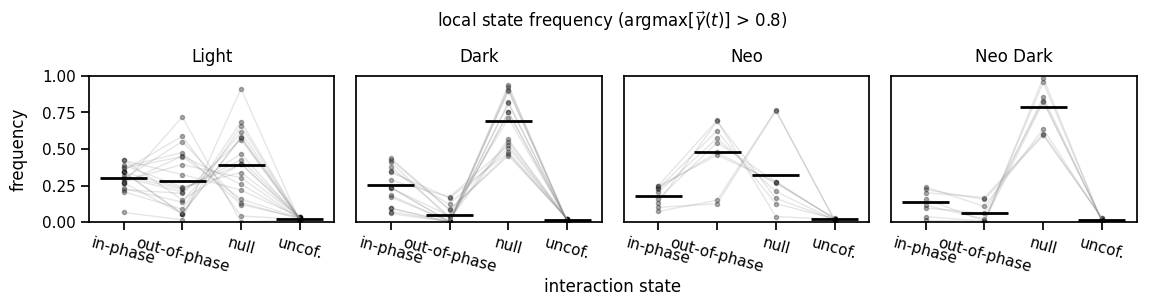

In [29]:
# plot state freqs
state_type = "local_thresh"  # choose 'viterbi' or 'thresh'
thresh_state_freqs_by_cond = get_plot_state_freqs(bdf[valid_IO_sel], state_type, num_states, state_labels, thresh=thresh)

Groups in Light condition: 20
Groups in Dark condition: 16
Groups in Neo condition: 9
Groups in Neo Dark condition: 8


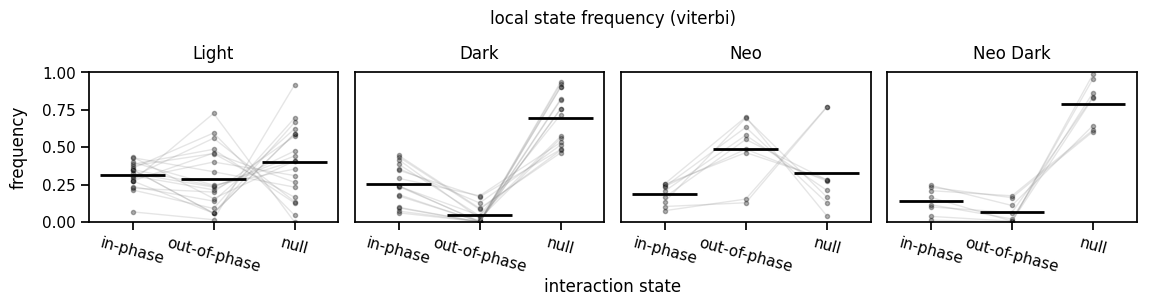

In [30]:
# plot state freqs
state_type = "local_viterbi"  # choose 'viterbi' or 'thresh'
vit_state_freqs_by_cond = get_plot_state_freqs(bdf[valid_IO_sel], state_type, num_states, state_labels, thresh=thresh)

# __Step 4__: Run M-step for each pair with fixed posteriors
____

Holding fixed the state posteriors obtained in 3b, we run the M-step one last time (maximize likelihood of model by updating emission model parameters). This allows us to compare variability in the model parameters between pairs and conditions.

## 4a. Run local M-steps

In [31]:
# use results from step 3b
g_posts = jnp.array(gammas_arr)
g_joints = jnp.array(xis_arr)

In [32]:
# specify whether to initialize params
Load = True

# choose hyper params
num_states = 3       # num of latent states in model
symm_weights = True  # constrain toeplitz weights to be symmetric
N_iters = 20         # num of EM iterations
TOL = 1e-4           # convergence threshold of LL for early stopping

# get params
tmat = model_params["transition_matrix"]
init_probs = model_params["initial_probs"]
flat_weights = model_params["flat_weights"]
biases = model_params["biases"]
scales = model_params["scales"]

# select model params to fit (only fit initial state probs and trans mat here)
fit_params_dict = {
    "fit_initial_state_probs": True,
    "fit_transition_matrix": True,
    "fit_weights": True,
    "fit_biases": True,
    "fit_scales": True
} 

In [33]:
# instantiate model
hmm = ConstrainedLinearRegressionSharedSphericalGaussianHMM(
    num_states,
    input_dim,
    emission_dim,
    symmetric=symm_weights,
    coupled_IO_fit=True
)

# initialize parameters
if Load:
    init_params, param_props = hmm.initialize(
        initial_probs=init_probs,
        transition_matrix=tmat,
        emission_flat_weights=flat_weights,
        emission_biases=biases,
        emission_scales=scales
    )
else:
    keys = map(jr.PRNGKey, count()) 
    init_params, param_props = hmm.initialize(key=next(keys), method="random")

# specify which model params to fit
param_props.initial.probs.trainable = fit_params_dict["fit_initial_state_probs"]
param_props.transitions.transition_matrix.trainable = fit_params_dict["fit_transition_matrix"]
param_props.emissions.flat_weights.trainable = fit_params_dict["fit_weights"]
param_props.emissions.biases.trainable = fit_params_dict["fit_biases"]
param_props.emissions.scales.trainable = fit_params_dict["fit_scales"]

In [34]:
def fit_mstep(params, props, emissions, inputs, gammas, xis):

    # expand first batch dimension
    emissions = jnp.expand_dims(emissions, axis=0)  # Shape: (1, ...)
    inputs = jnp.expand_dims(inputs, axis=0)
    gammas = jnp.expand_dims(gammas, axis=0)      
    xis = jnp.expand_dims(xis, axis=0)

    # construct batch stats 
    initial_stats = gammas[:,0]
    transition_stats = xis   
    emission_stats = (gammas, emissions, inputs)
    batch_stats = (initial_stats, transition_stats, emission_stats)
    
    # run m-step
    m_step_state = hmm.initialize_m_step_state(params, props)
    fit_params, m_step_state = hmm.m_step(params, props, batch_stats, m_step_state, coupled_IO_fit=True)
    
    return fit_params

In [35]:
# fit all batches individually
fit_params_arr = vmap(
    lambda emissions, inputs, gammas, xis: fit_mstep(
        init_params, param_props, emissions, inputs, gammas, xis
    )
)(dual_emissions, dual_inputs, g_posts, g_joints)

# use device_get to force computation (otherwise seems to "lazy" execute)
fit_params_arr = jax.device_get(fit_params_arr)

# unpack results
(final_init_probs,), (final_tmats,), (final_flat_weights, final_biases, final_scales) = fit_params_arr
final_Wks = vmap(hmm.emission_component.get_weights)(final_flat_weights)

## 4c. Compare weights between different groups

In [36]:
def compare_group_weights(
    weights_by_group, groups, biases_by_group, lag=lag, ipt_lag=ipt_lag, num_states=num_states, FPS=FPS, 
    define_lim=False, vmin=-0.06, vmax=0.18, display_bias=False, cmap="seismic", interp="spline16", figsize=(12,8)
):
    n_gs = len(groups)
    weights = np.array([weights_by_group[g] for g in groups])
    if not define_lim: 
        vmin, vmax = np.min(weights), np.max(weights)

    # make assymetric seismic colormap using TwoSlopeNorm: vmin = blue, 0 = white, vmax = dark red
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # set plot params
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(n_gs, num_states), axes_pad=0.4, cbar_location="right", cbar_mode="edge", cbar_size="5%", cbar_pad=0.25)

    # plot
    for g, group in enumerate(groups):
        for i in range(num_states):
            idx = g * num_states + i
            im = grid[idx].imshow(weights[g][i],interpolation=interp,norm=norm,extent=[-lag/FPS,lag/FPS,-ipt_lag/FPS,ipt_lag/FPS],cmap=cmap)
            grid[idx].set_xticks(np.linspace(-lag/FPS,lag/FPS,5))
            grid[idx].set_yticks(np.linspace(-ipt_lag/FPS,ipt_lag/FPS,5))
            grid[idx].set_xlabel('')
            # grid[idx].set_ylabel('Output Lag (s)',fontdict={'size':12})
            if i>0: plt.yticks([])
            if i==num_states-1: 
                cbar = plt.colorbar(im, cax=grid.cbar_axes[g])
                cbar.ax.set_yscale('linear')
            grid[idx].set_title(r'Group {} $\mathbf{{W}}^{{({})}}$'.format(group, i))
            grid[idx].spines['right'].set_visible(False)
            grid[idx].spines['top'].set_visible(False)
            if display_bias:
                grid[idx].text(x=0.65,y=1.65,s=r'$b^{{({})}} = {:.2f}$'.format(i,biases_by_group[group][i]))

    fig.add_subplot(111, frameon=False) 
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Input Lag (s)       ',fontdict={'size':14},labelpad=0)
    plt.ylabel('Output Lag (s)',fontdict={'size':14},labelpad=10)
    plt.show()

Notice that the spacing between the lobes of the weights (corresponding roughly to average interbout intervals in each state) differ between pairs. One example of this is group 3 vs. 9.

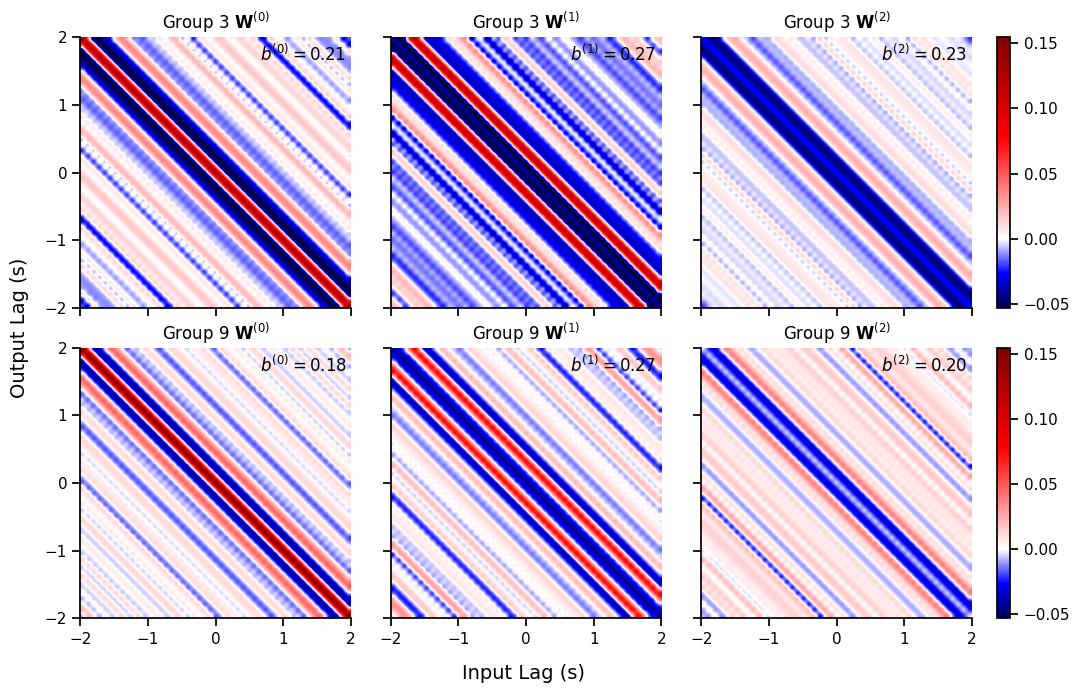

In [37]:
gs = [3,9]  # groups to compare
interp = "spline16"
figsize = (12, 8)
compare_group_weights(final_Wks, gs, final_biases, display_bias=True,interp=interp, figsize=figsize)

## 4d. Plot average slice of weights for each group

In [38]:
# organize parameters by class
cs = bdf["class"].unique().tolist()
Wks_by_class = [[] for _ in range(len(cs))]
mus_by_class = [[] for _ in range(len(cs))]
sigma_by_class = [[] for _ in range(len(cs))]

for c in cs:
    c_sel = (bdf["class"]==c)
    for g in bdf[c_sel]["group"].unique():
        Wks_by_class[c].append(final_Wks[g])        
        mus_by_class[c].append(final_biases[g])        
        sigma_by_class[c].append(final_scales[g])

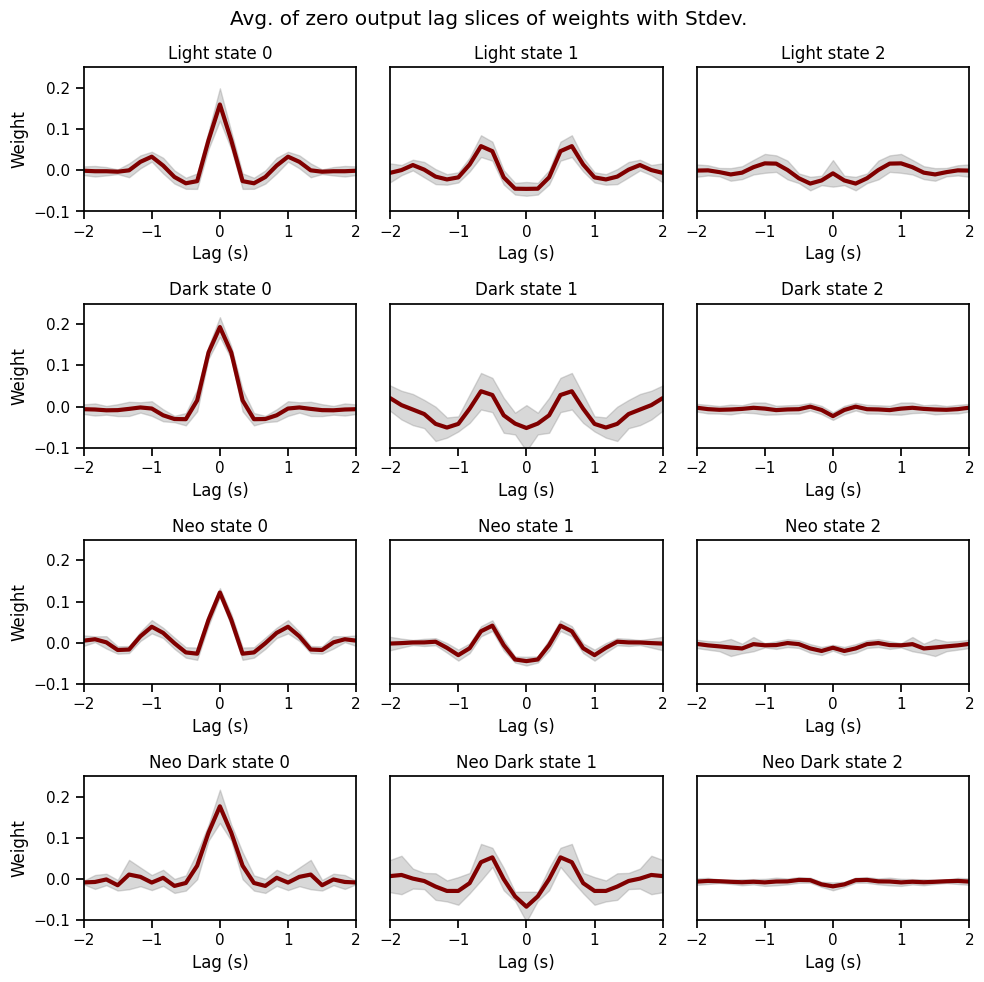

In [39]:
# Plot the mean of the 0 output lag slice of the weights with stdev
c_labels = ["Light","Dark","Neo","Neo Dark"]
means = []

xs = np.linspace(-(emission_dim-1)*q/FPS,(emission_dim-1)*q/FPS,emission_dim)
fig = plt.figure(figsize=(10,10))

# loop through each class
for c_num,c in enumerate(c_labels):

    # loop through each state
    for k in range(num_states):
        fig.add_subplot(4,num_states,k+1 + c_num*num_states)

        for i in range(len(Wks_by_class[c_num])):
            # plot 0 output lag slice of weights
            plt.plot(xs,Wks_by_class[c_num][i][k][int((emission_dim-1)/2)].T,alpha=0.0,color='black')
        
        # get mean and stdev of 0 output lag slice of weights
        mean = np.mean(Wks_by_class[c_num],axis=0)
        std = np.std(Wks_by_class[c_num],axis=0)
        means.append(mean)

        # plot mean and stdev
        plt.plot(xs,mean[k][int((emission_dim-1)/2)],color='maroon',lw=3)
        plt.fill_between(
            xs, 
            mean[k][int((emission_dim-1)/2)] - std[k][int((emission_dim-1)/2)], 
            mean[k][int((emission_dim-1)/2)] + std[k][int((emission_dim-1)/2)], 
            color='gray', alpha=0.3, label='Standard Deviation')

        # plot params
        plt.xlim(-2,2)
        plt.ylim(-0.10,0.25)
        plt.xlabel("Lag (s)")
        plt.ylabel("Weight")
        if k!=0:
            plt.ylabel('')
            plt.yticks([])
        plt.title("{} state {}".format(c,k))
        
plt.suptitle("Avg. of zero output lag slices of weights with Stdev. ")
plt.tight_layout()

See plots and explanation in 5b to see why the secondary lobes dissapear in the in-phase state (State 0) for the dark conditions. In summary, fish movement not as regular in the dark conditions meaning that the secondary lobes in the cross-correlation average out to ~0.

# __Step 5__: Plot interesting observables conditioned by state
___

First add the distance in mm to the dataframe for interpretable plots.

In [40]:
dist_mm = np.round(np.array(bdf['dist'],dtype=np.float32)/pix_mm,2)
if 'dist_mm' in bdf.columns.values.tolist(): 
    bdf = bdf.drop(columns=['dist_mm'])

bdf.insert(1,'dist_mm',dist_mm)

## 5a. Plot distance vs. relative heading heatmap

In [41]:
def rel_hang_dist_state_heat_maps_by_class(df,x_var='rel_hang',y_var='dist_mm',num_states=num_states,cmap='gist_yarg',save=False):
    class_label = ['Light','Dark','Neo','Neo Dark']
    state_sel = [(df['local_thresh_state']==k) for k in range(num_states)]
    c_sel = [(df['class']==c) for c in df['class'].unique()]

    fig = plt.figure(figsize=(8,6),dpi=200)
    for k in range(num_states):
        for c in df['class'].unique():
            ax = fig.add_subplot(num_states,4,k*4+c+1)
            axs = sns.kdeplot(df[c_sel[c] & state_sel[k]],x=x_var,y=y_var,fill=True,cbar=False,cmap=cmap,thresh=0,levels=50,gridsize=30)
            for p in axs.collections: p.set_edgecolor("face")
            plt.xlim(0,np.pi), plt.ylim(3,47)
            x_ticks = np.arange(0, 1*np.pi+0.01, np.pi/2) 
            labels = ['$0$', r'$\pi/2$', r'$\pi$']
            plt.xticks(x_ticks, labels=labels) 
            plt.yticks([10,20,30,40])
            plt.xlabel(''); plt.ylabel('')
            #if c==0: plt.annotate('State {}'.format(k),xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='x-large', ha='right', va='center')
            if k==0: plt.title(class_label[c],fontdict={'size':12})
            if k<num_states-1: plt.xticks([])
            if c>0: plt.yticks([])
            if c==3: 
                ax2 = ax.twinx()
                plt.yticks([])
                plt.annotate('State {}'.format(k),xy=(0.0, 0.5), xytext=(ax2.yaxis.labelpad + 52, 0), xycoords=ax2.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
    # add a big axes, hide frame, ticks, tick labels
    fig.add_subplot(111, frameon=False) 
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel(r'$\theta_{rel}$',fontdict={'size':12})
    #plt.xlabel("theta",fontdict={'size':12})
    plt.ylabel('Distance (mm)',fontdict={'size':12})
    plt.title('Distance vs. relative heading angle',pad=30,fontdict={'size':12})
    plt.tight_layout(pad=1.0,h_pad=1.2,w_pad=0.5)
    if save: plt.savefig("" + "/relative_heading_vs_dist.pdf", format='pdf', bbox_inches='tight')

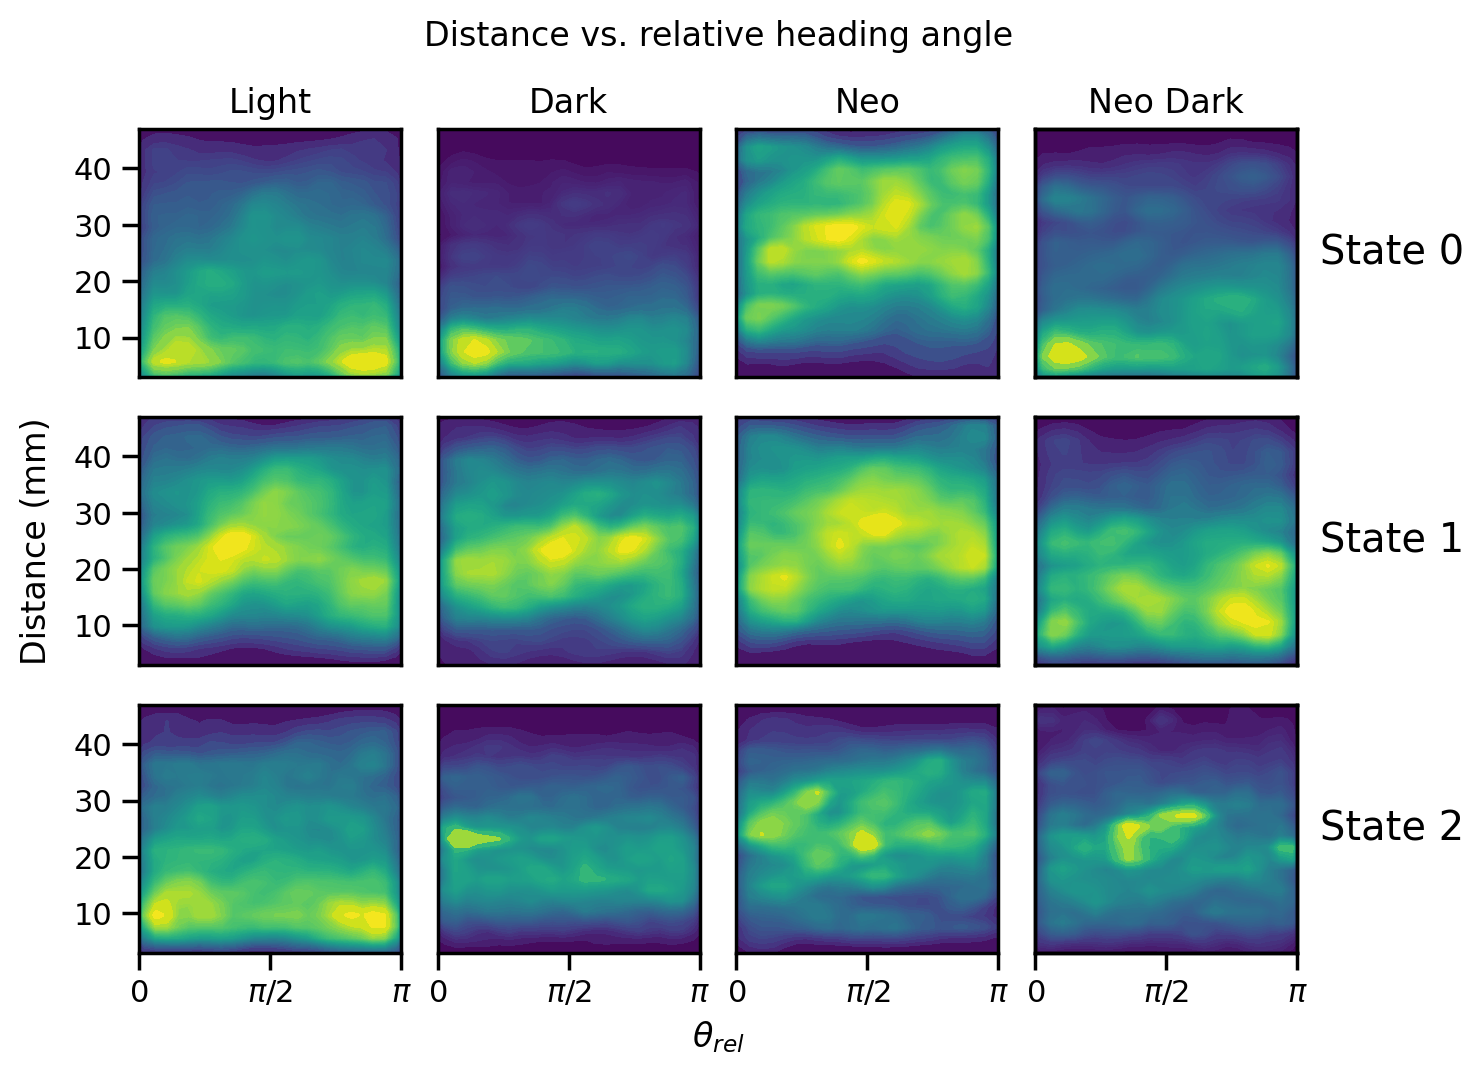

In [42]:
rel_hang_dist_state_heat_maps_by_class(bdf[valid_IO_sel], cmap='viridis')

Note that the identified states (especially in the light condition) demonstrate a distance dependence even though we never included distance information into the model fits! The in-phase interactions tend to occur at close range in parallel/antiparallel configurations, where as the out of phase state involves mid-range interactions.

## 5b. Plot phase response curves (PRC)

Next, we plot the period of the focal fish $T$ as a function of the response lag $\tau$ of the subsequent partner bout(s). The resulting heatmap will reveal if pairs are coordinating the timing of their movements. 

![image.png](attachment:image.png)

In [43]:
def get_repeated_subsequences_and_frames(sequence, frames):
    """
    Extracts repeated subsequences and their corresponding frame numbers.
    For example, the sequence [0,0,0,1,2,2,1] --> [[0,0,0],[1],[2,2],[1]].

    Parameters:
    - sequence: list or np.array, the sequence of elements.
    - frames: list or np.array, the corresponding frame numbers.

    Returns:
    - subsequences: list of lists, subsequences of repeated elements.
    - frame_numbers: list of lists, corresponding frame numbers for each subsequence.
    """
    subsequences = []
    frame_numbers = []

    current_subseq = [sequence[0]]
    current_frames = [frames[0]]

    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i - 1]:
            current_subseq.append(sequence[i])
            current_frames.append(frames[i])
        else:
            subsequences.append(current_subseq)
            frame_numbers.append(current_frames)
            current_subseq = [sequence[i]]
            current_frames = [frames[i]]

    subsequences.append(current_subseq)
    frame_numbers.append(current_frames)

    return subsequences, frame_numbers


def analyze_subsequences(sequence, frames):
    """
    Takes binary pulse trains of fish activity with corresponding frames. Pulses
    are composed of a active period (1s) followed by an inactive period (0s). We
    truncate leading 0s and the final incomplete period, then classify subsequences 
    within the pulse train as active or inactive and record the start frames.

    Parameters:
    - sequence (list or np.array): 1D sequence of elements.
    - frames   (list or np.array): Corresponding frame numbers.

    Returns:
    - low_start_frames (list): Start frames for inactive sequences.
    - low_durations    (list): Durations for inactive sequences
    - hi_start_frames  (list): Start frames for active sequences.
    - hi_durations     (list): Durations for active sequences.
    """

    # ensure sequence is array of shape (N,)
    sequence = np.array(sequence)
    assert np.array(sequence).ndim == 1

    # truncate leading 0s (inactive period)
    first_one_idx = np.argmax(sequence == 1)
    sequence = sequence[first_one_idx:]
    frames = frames[first_one_idx:]

    # remove last inactive period
    if sequence[-1] == 0:
        last_one_idx = len(sequence) - 1 - np.argmax(sequence[::-1] == 1)
        sequence = sequence[:last_one_idx + 1]
        frames = frames[:last_one_idx + 1]

    # remove last active sequence to ensure last period ends on completed inactive sequence
    last_zero_idx = len(sequence) - 1 - np.argmax(sequence[::-1] == 0)
    sequence = sequence[:last_zero_idx + 1]
    frames = frames[:last_zero_idx + 1]

    # get repeated subsequences and frames
    subsequences, frame_numbers = get_repeated_subsequences_and_frames(sequence, frames)

    # initialize lists for start frames and durations
    low_start_frames = []
    low_durations = []
    hi_start_frames = []
    hi_durations = []

    # iterate over subsequences to calculate start frames and durations
    for subseq, frames in zip(subsequences, frame_numbers):

        start_frame = frames[0]
        duration = len(subseq)

        if subseq[0] == 0:  # inactive sequence
            low_start_frames.append(start_frame)
            low_durations.append(duration)

        elif subseq[0] == 1:  # active sequence
            hi_start_frames.append(start_frame)
            hi_durations.append(duration)

    return low_start_frames, low_durations, hi_start_frames, hi_durations

In [44]:
def get_prc_df(df, focal_hi_frames, partner_hi_frames, focal_low_frames, partner_low_frames, 
               focal_hi_durs, partner_hi_durs, focal_low_durs, partner_low_durs,
               state_type="local_thresh_state", verbose=False):
    """
    Construct data frame with the durations of active & inactive periods and the frames
    in which they begin for both the focal and partner fish. 
    """

    # init lists
    data = []

    # record number of bouts focal fish initiates that partner does not respond to
    focal_bouts_w_no_response = 0

    # get num of focal bouts
    n_bouts = len(focal_hi_frames)

    # get frames and states
    df_frames = df["frame"].values
    df_states = df[state_type].values

    for i in range(n_bouts):
        focal_start = focal_hi_frames[i]
        focal_period_end = focal_hi_frames[i + 1] if i < n_bouts - 1 else np.inf

        valid_partner_bouts = [
                    (frame, partner_low_frames[idx], partner_hi_durs[idx], partner_low_durs[idx])
                for idx, frame in enumerate(partner_hi_frames)
            if focal_start <= frame < focal_period_end  # include 0-lag response
        ]

        if not valid_partner_bouts:
            #print(f"No valid partner bouts found for focal bout at frame {focal_start}.")
            focal_bouts_w_no_response += 1

        for j, (partner_hi_start, partner_low_start, p_hi_dur, p_low_dur) in enumerate(valid_partner_bouts):

            response_lag = partner_hi_start - focal_start
            is_first_response = (j == 0)

            focal_lo_start  = focal_low_frames[i] if i < len(focal_low_frames) else np.nan
            f_hi_dur = focal_hi_durs[i] if i < len(focal_hi_durs) else np.nan
            f_lo_dur = focal_low_durs[i] if i < len(focal_low_durs) else np.nan

            # select frames between start of focal fish active sequence and the 
            # end of the responding partners active sequence
            f_sel = (df_frames >= focal_start) & (df_frames <= (partner_hi_start + p_hi_dur))
            states = df_states[f_sel]

            # determine the state
            unique_states = np.unique(states)
            state = unique_states[0] if len(unique_states) == 1 else np.nan

            # get focal period
            f_period = f_hi_dur + f_lo_dur

            data.append([
                focal_start,
                f_hi_dur,
                focal_lo_start,
                f_lo_dur,
                partner_hi_start,
                p_hi_dur,
                partner_low_start,
                p_low_dur,
                response_lag,
                f_period,
                state,
                is_first_response,
            ])

    # create dataframe
    response_lags_df = pd.DataFrame(data, columns=[
        "focal_hi_start_frame", 
        "focal_hi_duration", 
        "focal_low_start_frame", 
        "focal_low_duration", 
        "partner_hi_start_frame", 
        "partner_hi_duration", 
        "partner_low_start_frame", 
        "partner_low_duration", 
        "partner_response_lag", 
        "focal_period",
        "state",
        "first_response",
    ])

    if verbose:
        print("partner did not respond to {} out of {} focal periods".format(focal_bouts_w_no_response, n_bouts))

    return response_lags_df


def get_prc_df_by_group_class(
        bdf, focal_fish_num,
        f_low_frames_by_class_group, f_hi_frames_by_class_group, f_low_durations_by_class_group, f_hi_durations_by_class_group, 
        p_low_frames_by_class_group, p_hi_frames_by_class_group, p_low_durations_by_class_group, p_hi_durations_by_class_group,
        state_type="local_thresh_state"):
    
    df_list = []
    
    # loop through conditions
    for c, condition in enumerate(bdf["class"].unique()):
        c_sel = (bdf["class"] == condition)

        # loop through groups within condition
        for g, group in enumerate(bdf[c_sel]["group"].unique()):

            # select group
            g_sel = (bdf["group"] == group)
            
            # focal fish data
            f_low_frms_c_g = f_low_frames_by_class_group[c][g]
            f_low_durs_c_g = f_low_durations_by_class_group[c][g]
            f_hi_frms_c_g = f_hi_frames_by_class_group[c][g]
            f_hi_durs_c_g = f_hi_durations_by_class_group[c][g]

            # partner fish data
            p_low_frms_c_g = p_low_frames_by_class_group[c][g]
            p_low_durs_c_g = p_low_durations_by_class_group[c][g]
            p_hi_frms_c_g = p_hi_frames_by_class_group[c][g]
            p_hi_durs_c_g = p_hi_durations_by_class_group[c][g]

            # make df for group
            g_df = get_prc_df(
                bdf[g_sel], 
                f_hi_frms_c_g, p_hi_frms_c_g, f_low_frms_c_g, p_low_frms_c_g,
                f_hi_durs_c_g, p_hi_durs_c_g, f_low_durs_c_g, p_low_durs_c_g,
                state_type
            )

            # add columns: focal fish number, group, condition
            g_df["focal_fish"] = focal_fish_num
            g_df["group"] = group
            g_df["class"] = condition

            # append to list
            df_list.append(g_df)

    return pd.concat(df_list)

In [45]:
# get list of conditions
cs = bdf["class"].unique().tolist()

# init lists to store start frame and durations of active sequences
f0_hi_start_frames_by_class_group = [[] for _ in cs]
f0_hi_durs_by_class_group = [[] for _ in cs]
f1_hi_start_frames_by_class_group = [[] for _ in cs]
f1_hi_durs_by_class_group = [[] for _ in cs]

# init lists to store start frame and durations of inactive sequences
f0_lo_start_frames_by_class_group = [[] for _ in cs]
f0_lo_durs_by_class_group = [[] for _ in cs]
f1_lo_start_frames_by_class_group = [[] for _ in cs]
f1_lo_durs_by_class_group = [[] for _ in cs]

# loop through groups
for g in bdf["group"].unique():

    # select group and get condition
    g_sel = (bdf["group"] == g)
    cond = bdf[g_sel]["class"].unique()[0]

    # get frames and binary bout sequences for each fish (only for valid IO frames)
    frames = bdf[valid_IO_sel & g_sel]["frame"].tolist()
    f0_bout_seq = bdf[valid_IO_sel & g_sel]["f0_bout_seq"].to_list()
    f1_bout_seq = bdf[valid_IO_sel & g_sel]["f1_bout_seq"].to_list()

    # get active and inactive sequence start frames and durations
    f0_low_start_frames, f0_low_durations, f0_hi_start_frames, f0_hi_durations = analyze_subsequences(f0_bout_seq, frames)
    f1_low_start_frames, f1_low_durations, f1_hi_start_frames, f1_hi_durations = analyze_subsequences(f1_bout_seq, frames)

    # append to lists
    f0_hi_start_frames_by_class_group[cond].append(f0_hi_start_frames)
    f1_hi_start_frames_by_class_group[cond].append(f1_hi_start_frames)
    f0_hi_durs_by_class_group[cond].append(f0_hi_durations)
    f1_hi_durs_by_class_group[cond].append(f1_hi_durations)

    f0_lo_start_frames_by_class_group[cond].append(f0_low_start_frames)
    f1_lo_start_frames_by_class_group[cond].append(f1_low_start_frames)
    f0_lo_durs_by_class_group[cond].append(f0_low_durations)
    f1_lo_durs_by_class_group[cond].append(f1_low_durations)

In [46]:
# choose "local_thresh_state" for thresheld states, "local_states" for viterbi states
state_type = "local_thresh_state"

# get dataframe with fish 0 as the focal fish
f0_focal_PRC_df = get_prc_df_by_group_class(
    bdf[valid_IO_sel], 0,
    f0_lo_start_frames_by_class_group, f0_hi_start_frames_by_class_group, f0_lo_durs_by_class_group, f0_hi_durs_by_class_group,
    f1_lo_start_frames_by_class_group, f1_hi_start_frames_by_class_group, f1_lo_durs_by_class_group, f1_hi_durs_by_class_group,
    state_type
)

# get dataframe with fish 1 as the focal fish
f1_focal_PRC_df = get_prc_df_by_group_class(
    bdf[valid_IO_sel], 1,
    f1_lo_start_frames_by_class_group, f1_hi_start_frames_by_class_group, f1_lo_durs_by_class_group, f1_hi_durs_by_class_group,
    f0_lo_start_frames_by_class_group, f0_hi_start_frames_by_class_group, f0_lo_durs_by_class_group, f0_hi_durs_by_class_group,
    state_type
)

# combine dataframes
PRC_df = pd.concat([f0_focal_PRC_df, f1_focal_PRC_df])
PRC_df = PRC_df.reset_index(drop=True)

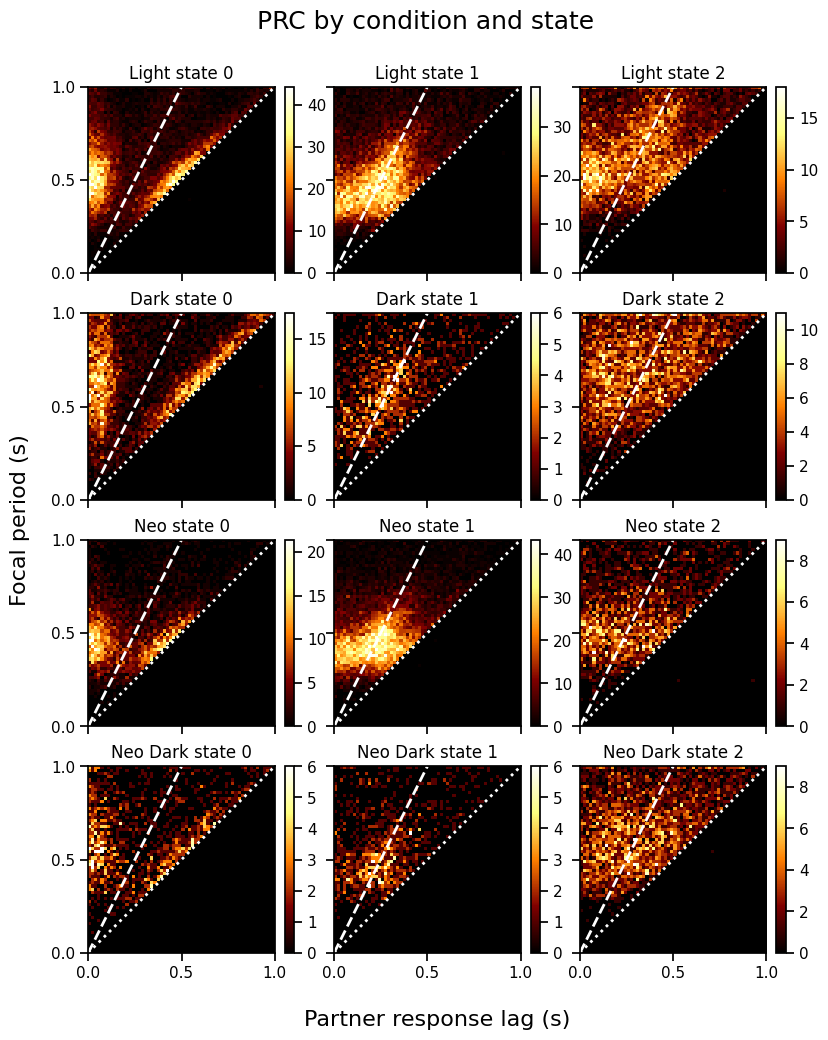

In [47]:
# create a grid of IBI and bout length values
x_max = 60 #36
y_max = 60 #54
x_range = np.arange(x_max+1) # bout timing difference
y_range = np.arange(y_max+1) # focal fish period
grid_x, grid_y = np.meshgrid(x_range, y_range)

# select conditions to plot
conds = PRC_df["class"].unique()
n_conds = len(conds)

# set plot params
cmp = "afmhot"
figsize = (9, 3*len(conds))
fig = plt.figure(figsize=figsize)
grid = ImageGrid(fig, 111, nrows_ncols=(n_conds, num_states), axes_pad=0.4, cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad=0.1)
fixed_cbar_lims = False

# plot grid
heatmaps_by_class_state = []

# loop through conditions
for c, c_num in enumerate(conds):
    heatmaps_by_state = [[] for _ in range(num_states)]

    # loop through states
    for s in range(num_states):

        # get plot index
        i = c * num_states + s

        # select class and state
        c_s_sel = (PRC_df["class"] == c_num) & (PRC_df["state"] == s)

        # get periods and corresponding partner response lags
        f_periods = PRC_df[c_s_sel]["focal_period"].tolist()
        p_resp_lags = PRC_df[c_s_sel]["partner_response_lag"].tolist()

        # plot histogram
        heatmap, xedges, yedges = np.histogram2d(p_resp_lags, f_periods, bins=(x_range, y_range), density=False)
        heatmaps_by_state[s] = heatmap.T

        # set colorbar min and max and plot heatmap + colorbar
        if fixed_cbar_lims: 
            vmax = 0.004
        else: 
            max_color_percentile = 99.9
            vmax = np.percentile(heatmap, max_color_percentile)
        im = grid[i].imshow(heatmap.T, origin='lower', aspect='equal', cmap=cmp, vmin=0, vmax=vmax, extent=[0, x_max, 0, y_max])
        cbar = plt.colorbar(im, cax=grid.cbar_axes[i])

        # overlay y=x and y=2x lines
        grid[i].plot([0, x_max], [0, x_max], color='white', linestyle=':', linewidth=2, label='y=x')
        grid[i].plot([0, y_max/2], [0, y_max], color='white', linestyle='--', linewidth=2, label='y=2x')

        # display y_labels, y_ticks, and x_ticks only along border of plot
        if s==0: 
            #grid[i].set_ylabel(r'$T$  (s)')
            y_ticks = np.linspace(0,y_max,3)
            y_labels = (y_ticks / FPS).round(2)  
            grid[i].set_yticks(y_ticks,y_labels)

        if c==n_conds-1:
            x_ticks = np.linspace(0,x_max,3)
            x_labels = (x_ticks / FPS).round(2)
            grid[i].set_xticks(x_ticks,x_labels)

        grid[i].set_ylim(0,y_max)
        grid[i].set_xlim(0,x_max)
        grid[i].set_title(c_labels[c_num] + ' state {}'.format(s))

    heatmaps_by_class_state.append(heatmaps_by_state)

fig.add_subplot(111, frameon=False) 
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Partner response lag (s)',fontdict={'size':16},labelpad=0)
plt.ylabel('Focal period (s)',fontdict={'size':16},labelpad=15)
plt.suptitle("PRC by condition and state",size=18,x=0.5,y=0.92)
plt.show()

Although the model fits did not include any phase information, the identified states clearly demonstrate in- and out-of-phase coupling in states 0 and 1. 

Some interesting things to note:
- The null state PRC in the light condition (State 2) exhibits denser lobes around the $y=x$ and $y=2x$ lines. This may result from the rapid engagement-and-disengagement interactions that occur and temporarily trigger the null state (i.e. during the in-phase interaction, fish at close range may momentarily break coupling when orienting away from each other). Consequently, some interactions could occur before the most probable state returns to the correct interaction state, leaving behind a faint, residual structure in the PRC. This structure is not evident in any other condition.

- The out-of-phase PRCs in the light and neo conditions both contain a dense lobe along the $y=2x$ line superimposed on a rectangular lobe. The rectangular lobe is what one would expect to see from independently swimming fish. This suggests that the out-of-phase coupling may be weak and periodically shift into uncorrelated movement before realigning. Additionally, the model may be misclassifying some fraction of null interactions. These combined effects likely explain the presence of the rectangular lobe.

- Each horizontal slice of the heatmap is related to the cross-correlation. This demonstrates that the cross-correlated structure of fish speeds actually stretches and compresses over time, whereas our model assumes a fixed structure. Essentially, our model ignores the variable lobe spacing of the cross-correlation and identifies the average value for each interaction state. This suggests that our model may benefit from the inclusion of some non-linear warping variable on the weights that allows for variable lobe spacing.